In [3]:
import json
import shelve
from tqdm import tqdm

import matplotlib.pyplot as plt

from data.ag.action_genome import AG, AGViewer
from util.graph_utils import check_edge_exists

%load_ext autoreload


In [4]:
root = '/data/Datasets/ag/'
ag = AG(root, split=None, subset_file=None) #view the full dataset

In [3]:
for i,a in enumerate(ag.action_classes):
    print(a)

Holding some clothes
Putting clothes somewhere
Taking some clothes from somewhere
Throwing clothes somewhere
Tidying some clothes
Washing some clothes
Closing a door
Fixing a door
Opening a door
Putting something on a table
Sitting on a table
Sitting at a table
Tidying up a table
Washing a table
Working at a table
Holding a phone/camera
Playing with a phone/camera
Putting a phone/camera somewhere
Taking a phone/camera from somewhere
Talking on a phone/camera
Holding a bag
Opening a bag
Putting a bag somewhere
Taking a bag from somewhere
Throwing a bag somewhere
Closing a book
Holding a book
Opening a book
Putting a book somewhere
Smiling at a book
Taking a book from somewhere
Throwing a book somewhere
Watching/Reading/Looking at a book
Holding a towel/s
Putting a towel/s somewhere
Taking a towel/s from somewhere
Throwing a towel/s somewhere
Tidying up a towel/s
Washing something with a towel
Closing a box
Holding a box
Opening a box
Putting a box somewhere
Taking a box from somewhere
T

In [5]:
for i,a in enumerate(ag.verb_classes):
    print(a)
print(len(ag.verb_classes))


awaken
close
cook
dress
drink
eat
fix
grasp
hold
laugh
lie
make
open
photograph
play
pour
put
run
sit
smile
sneeze
snuggle
stand
take
talk
throw
tidy
turn
undress
walk
wash
watch
work
33


In [5]:
for a, (v, o) in sorted(ag.action_verb_obj_map.items(), key=lambda x: x[1][0]):
    action = ag.action_classes[a]
    verb = ag.verb_classes[v]
    obj = None if o is None else ag.object_classes[o]
    if verb == 'hold':
        print(action, f'({verb}, {obj})')

Holding some clothes (hold, clothes)
Holding a phone/camera (hold, phone/camera)
Holding a bag (hold, bag)
Holding a book (hold, book)
Holding a towel/s (hold, towel)
Holding a box (hold, box)
Holding a laptop (hold, laptop)
Holding a shoe/shoes (hold, shoe)
Holding some food (hold, food)
Holding a sandwich (hold, sandwich)
Holding a blanket (hold, blanket)
Holding a pillow (hold, pillow)
Holding a picture (hold, picture)
Holding a mirror (hold, mirror)
Holding a broom (hold, broom)
Holding a cup/glass/bottle of something (hold, cup/glass/bottle)
Someone is holding a paper/notebook (hold, paper/notebook)
Holding a dish (hold, dish)
Holding some medicine (hold, medicine)
Holding a vacuum (hold, vacuum)


In [6]:
for b in ag.object_classes:
    print(b)

person
bag
bed
blanket
book
box
broom
chair
closet/cabinet
clothes
cup/glass/bottle
dish
door
doorknob
doorway
floor
food
groceries
laptop
light
medicine
mirror
paper/notebook
phone/camera
picture
pillow
refrigerator
sandwich
shelf
shoe
sofa/couch
table
television
towel
vacuum
window


In [7]:
for r in ag.relationship_classes:
    print(r)

looking_at
not_looking_at
unsure
above
beneath
in_front_of
behind
on_the_side_of
in
carrying
covered_by
drinking_from
eating
have_it_on_the_back
holding
leaning_on
lying_on
not_contacting
other_relationship
sitting_on
standing_on
touching
twisting
wearing
wiping
writing_on


In [8]:
print(len(ag))

33432


INDEX: 3240
LABEL: UNMARKED
ACTION: Closing a closet/cabinet
VERB-OBJ: close closet/cabinet
VIDEO-FRAME-ACTION ID: FM078.mp4/000645.png_112
[('person', 'looking_at', 'shelf'), ('shelf', 'in_front_of', 'person'), ('person', 'touching', 'shelf'), ('person', 'looking_at', 'closet/cabinet'), ('closet/cabinet', 'in_front_of', 'person'), ('closet/cabinet', 'on_the_side_of', 'person'), ('person', 'not_contacting', 'closet/cabinet'), ('person', 'not_looking_at', 'groceries'), ('groceries', 'beneath', 'person'), ('person', 'touching', 'groceries')]


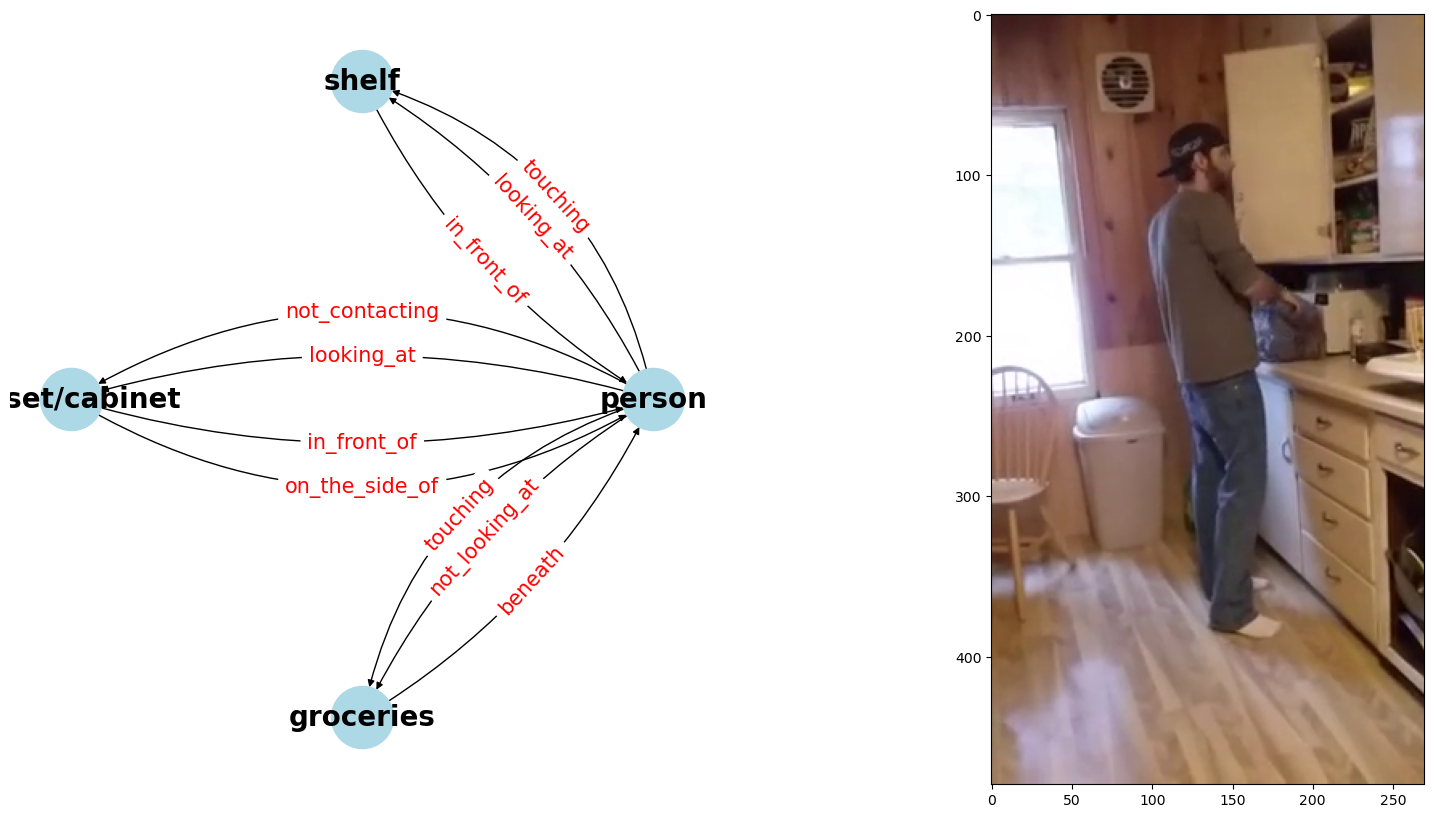

In [25]:
%autoreload

with shelve.open('data/ag/subset_shelve') as subset_dict:
    agview = AGViewer(ag, subset_dict)
    agview.view(0)
    while True:
        answer = input(f"{agview.message}current search key : {str(agview.key)}")
        new_idx = agview.process_command(answer)
        if new_idx is not None:
            agview.view(new_idx)
        else:
            break


In [18]:
%autoreload

#apply some initial heuristics
with shelve.open('data/ag/subset_shelve') as subset_dict:

    absent_count = 0
    invalid_precond_count = 0
    total_invalid = 0
    total_dodged = 0
    for idx in range(len(ag)):
        id, img, sg, action, constraints = ag[idx]

        verb, obj = ag.action_verb_obj_map[action]
        verb_name = ag.verb_classes[verb]


        # TESTING
        #if verb_name != 'hold':
        #    print('VERB FILTERED:', idx)
        #    subset_dict[id] = 'False'
        #    continue

        subset_dict[id] = 'UNMARKED'

        #ensure objects are present
        if obj is not None and obj not in sg.node_type:
            print('ABSENT OBJ:', idx)
            subset_dict[id] = 'False'
            absent_count+=1

        #ensure examples are actually preconditions
        if verb_name in ag.verb_result_rel_map.keys():
            bad_rels = ag.verb_result_rel_map[verb_name]
            for bad_rel in bad_rels:
                rel = ag.relationship_classes.index(bad_rel)
                rel_name = ag.relationship_classes[rel]
                if check_edge_exists(sg, rel, 0, obj):
                    print('INVALID PRECOND:', idx)
                    subset_dict[id] = 'False'
                    invalid_precond_count+=1
                    break
            if subset_dict[id] != 'False':
                total_dodged+=1
        if subset_dict[id] == 'False':
            total_invalid+=1

    print('LEN:', len(ag))
    print('TOTAL ABSENT:', absent_count)
    print('TOTAL INVALID PRECOND:', invalid_precond_count)
    print('TOTAL DEFECTS:', absent_count + invalid_precond_count)
    print('TOTAL INVALID:', total_invalid)
    print('TOTAL DODGED:', total_dodged)

ABSENT OBJ: 0
ABSENT OBJ: 1
ABSENT OBJ: 4
ABSENT OBJ: 5
INVALID PRECOND: 8
INVALID PRECOND: 11
INVALID PRECOND: 12
INVALID PRECOND: 13
INVALID PRECOND: 15
INVALID PRECOND: 16
ABSENT OBJ: 17
ABSENT OBJ: 18
ABSENT OBJ: 24
INVALID PRECOND: 25
ABSENT OBJ: 26
INVALID PRECOND: 27
ABSENT OBJ: 28
INVALID PRECOND: 29
ABSENT OBJ: 33
ABSENT OBJ: 35
ABSENT OBJ: 40
INVALID PRECOND: 41
ABSENT OBJ: 43
ABSENT OBJ: 45
ABSENT OBJ: 49
ABSENT OBJ: 51
ABSENT OBJ: 53
INVALID PRECOND: 54
ABSENT OBJ: 56
ABSENT OBJ: 58
ABSENT OBJ: 59
ABSENT OBJ: 60
ABSENT OBJ: 61
ABSENT OBJ: 62
ABSENT OBJ: 63
ABSENT OBJ: 65
ABSENT OBJ: 66
ABSENT OBJ: 67
ABSENT OBJ: 68
ABSENT OBJ: 69
ABSENT OBJ: 70
ABSENT OBJ: 71
ABSENT OBJ: 72
ABSENT OBJ: 73
ABSENT OBJ: 74
ABSENT OBJ: 75
ABSENT OBJ: 80
ABSENT OBJ: 81
INVALID PRECOND: 82
INVALID PRECOND: 83
ABSENT OBJ: 86
INVALID PRECOND: 87
INVALID PRECOND: 89
ABSENT OBJ: 91
INVALID PRECOND: 93
ABSENT OBJ: 95
INVALID PRECOND: 96
ABSENT OBJ: 97
INVALID PRECOND: 101
ABSENT OBJ: 106
ABSENT OBJ: 1

In [19]:
len(ag)

33432

In [26]:
id, img, sg, action = ag[1]
print(sg.edge_index.T)

tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 2],
        [2, 0],
        [2, 0],
        [0, 2]])


In [58]:
id, img, sg, action = ag[1]
rel = ag.relationship_classes.index('eating')
src = ag.object_classes.index('person')
dst = ag.object_classes.index('floor')
print(rel, src, dst)

check_edge_exists(sg, rel, src, None)

12 0 15
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 2],
        [2, 0],
        [2, 0],
        [0, 2]])
[]


False

In [13]:
action_hist = {}
verb_hist = {}
for idx in tqdm(range(len(ag))):
    id, img, sg, action = ag[idx]
    verb, obj = ag.action_verb_obj_map[action]

    if action not in action_hist:
        action_hist[action] = 0
    action_hist[action]+=1

    if verb not in verb_hist:
        verb_hist[verb] = 0
    verb_hist[verb]+=1

100%|██████████| 33432/33432 [01:08<00:00, 491.49it/s]


In [14]:
sorted_verbs = sorted(verb_hist.items(), key=lambda x: x[1], reverse=True)

for k,v in sorted_verbs:
    print(ag.verb_classes[k], v)
#plt.hist(list(action_hist.values()), bins=range(1, 10))


hold 5813
put 4768
take 3613
sit 2378
open 2024
close 1308
watch 1217
tidy 1128
walk 1095
eat 1079
throw 1066
stand 1017
drink 833
smile 832
play 540
sneeze 451
laugh 427
undress 404
wash 395
grasp 372
dress 352
turn 293
lie 265
snuggle 254
work 242
awaken 233
run 211
pour 196
fix 179
cook 159
photograph 158
talk 112
make 18


In [ ]:
# split the dataset into train and validation
import csv
import json
import random

'''
in fact these will make up the full dataset.
we will split the Charades 'train' into our own train and val with sampling
'''
full_video_ids = []    
with open('/data/Datasets/ag/annotations/Charades/Charades_v1_train.csv') as f:
    reader = csv.reader(f)
    reader.__next__()
    for row in reader:
        full_video_ids.append(row[0])

print(len(full_video_ids))

def split_list(lst, ratio):
    # Shuffle the list to ensure randomness
    random.shuffle(lst)
    
    # Calculate the split index based on the ratio
    split_index = int(len(lst) * ratio)
    
    # Split the list into two partitions
    partition1 = lst[:split_index]
    partition2 = lst[split_index:]
    
    return partition1, partition2

train_split_ids, val_split_idx = split_list(full_video_ids, 0.8)

split_dict = {'train': train_split_ids, 'val': val_split_idx}
with open('data/ag/split_train_val.json', 'w') as f:
    json.dump(split_dict, f)


7985


In [20]:
# split the dataset into train, val, and test
import csv
import json
import random

'''
in fact these will make up the full dataset.
we will split the Charades 'train' into our own train and val with sampling
'''
full_video_ids = []    
with open('/data/Datasets/ag/annotations/Charades/Charades_v1_train.csv') as f:
    reader = csv.reader(f)
    reader.__next__()
    for row in reader:
        full_video_ids.append(row[0])

print(len(full_video_ids))

def split_list(lst, ratio_train, ratio_val):
    # Shuffle the list to ensure randomness
    random.shuffle(lst)
    
    # Calculate the split index based on the ratio
    split_index_train = int(len(lst) * ratio_train)
    split_index_val = split_index_train + int(len(lst) * ratio_val)
    
    # Split the list into two partitions
    partition1 = lst[:split_index_train]
    partition2 = lst[split_index_train:split_index_val]
    partition3 = lst[split_index_val:]
    
    return partition1, partition2, partition3

train_split_ids, val_split_ids, test_split_ids = split_list(full_video_ids, 0.8, 0.1)

split_dict = {'train': train_split_ids, 'val': val_split_ids, 'test': test_split_ids}
with open('data/ag/split_train_val_test.json', 'w') as f:
    json.dump(split_dict, f)


7985


In [16]:
import json

with open('data/ag/split_train_val_test.json', 'r') as f:
    split_dict = json.load(f)
    train_ids = set(split_dict['train'])
    val_ids = set(split_dict['val'])
    test_ids = set(split_dict['test'])
    
    # Check for overlap
    train_val_overlap = train_ids.intersection(val_ids)
    train_test_overlap = train_ids.intersection(test_ids)
    val_test_overlap = val_ids.intersection(test_ids)

    if len(train_val_overlap) > 0 or len(train_test_overlap) > 0 or len(val_test_overlap) > 0:
        print(f"Warning: Found overlapping IDs between train and val splits")
    else:
        print("No overlap found between train and test splits")


No overlap found between train and test splits
